# Predicting Bike Rentals


## Introduction to the Dataset

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The data was compiled into a CSV file by [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home).  The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. Information can be downloaded  from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The goal of this project is to predict the total number of bikes people rented in a given hour. 


Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

%matplotlib inline
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import math


pd.options.display.max_columns = 999

In [2]:
data = pd.read_csv('bike_rental_hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


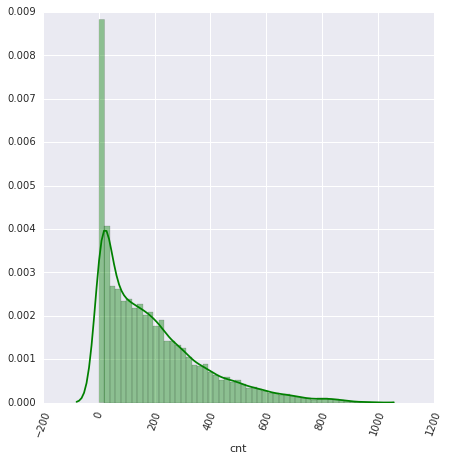

In [4]:
#Make a histogram of the 'cnt' column of data, and take a look at the distribution of total rentals.

fig, ax = plt.subplots(figsize=(7,7))
sns.distplot(data['cnt'], color='green')
plt.xticks(rotation=70)
plt.show()

In [5]:
#Use the corr method on the data to explore how each column is correlated with 'cnt'.

# make a correlation map
corrmat = data.corr()

#select just the 'cnt' column from the resulting data frame,
#sort the resulting Series by the correlation values
sorted_corrs = corrmat['cnt'].sort_values()
 
#Select only the columns in sorted_corrs with a correlation above 0.001
strong_corrs = sorted_corrs[sorted_corrs >.001]
strong_corrs


weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

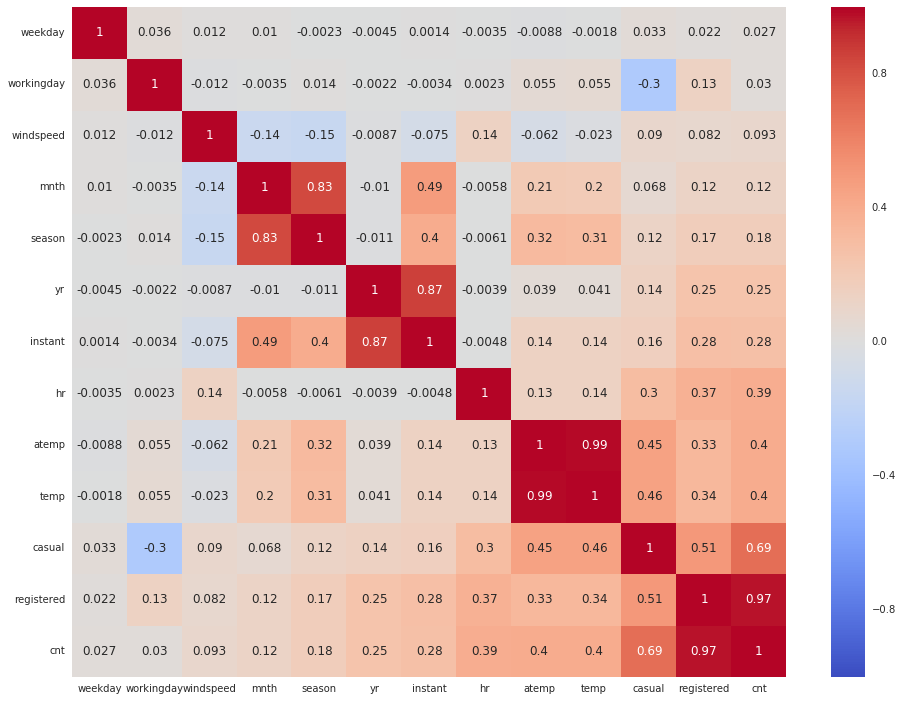

In [6]:
# make a correlation map 
corrmat = data[strong_corrs.index].corr()

#draw the heatmap
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corrmat, annot = True, cmap= 'coolwarm')


 Based on the correlation matrix heatmap, I can tell that the 'cnt' column strongly correlated with:

- registered
- temp
- instant
- season

I need to ignore the 'casual' and 'registered' columns because 'cnt' is derived from them.



## Calculating Features

Features can enhance the accuracy of models by introducing new information or distilling existing information. For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. Let's introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.


In [7]:
# let's write a function called assign_label that takes in a numeric value for an hour and return a label
def assign_label(hr):
    if 6 <= hr < 12:
        return 1
    if 12 <= hr < 18:
        return 2
    if 18 <= hr < 24:    
        return 3
    if 0 <= hr < 6: 
        return 4

In [8]:
# create a new column
data['time_label'] = data['hr'].apply(assign_label)
data['time_label'].head(10)

0    4
1    4
2    4
3    4
4    4
5    4
6    1
7    1
8    1
9    1
Name: time_label, dtype: int64

## Splitting the Data Into Train and Test Sets

Before applying machine learning algorithms let's split the data into training and testing sets.

In [9]:
#randomize the data
data_random = data.sample(frac=1, random_state=1)

#index for splitting
training_test_index = round(len(data_random) * .8)

#select 80% of the rows in data_random to be part of the training set 
train = data_random[:training_test_index].reset_index(drop=True)

#select 20% of the rows in data_random to be part of the test set
test = data_random[training_test_index:].reset_index(drop=True)

In [10]:
train.shape[0]

13903

In [11]:
test.shape[0]

3476

## Error metric

In this case I think that mean squared error metric is a good for evaluating error because the MSE makes the gap between the predicted and actual values more clear and the MSE works on continuous numeric data. In our dara set the vast majority of data is numeric.



## Applying Linear Regression


In [12]:
# create a list of predictor columns to use in training and predictions
features = data.drop(labels=['cnt', 'casual', 'registered', 'dteday', 'instant', 'weathersit'], axis=1) 
features = list(features) 

# use the LinearRegression class from sklearn to train a machine learning algorithm on train
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)


print(mse)

17068.814030523678


So the error is 17068.81. This is so big that's why we should try another algorithm. Let's use the decision tree.

## Applying Decision Trees

In [13]:
# use the DecisionTreeRegressor class to fit a decision tree algorithm to the train data.
clf = DecisionTreeClassifier(random_state=1)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test["cnt"]) ** 2)

print(error)


6296.413406214039


In [14]:
# let's include the 'min_samples_leaf' parameter to see how the error would be change
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=10)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test["cnt"]) ** 2)

print(error)

10929.341772151898


In [15]:
# let's change 'min_samples_leaf' parameter to 5
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=5)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test["cnt"]) ** 2)

print(error)

10229.93843498274


As I see if 'min_samples_leaf' parameter is 2 (by default) then the predictions of Decision tree have the smallest error.


##  Applying Random Forests

Let's now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per lea

In [16]:
# use the RandomForestRegressor class to fit a random forest algorithm to the train data.
clf = RandomForestRegressor(min_samples_leaf=5)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test['cnt']) ** 2)

print(error)


2383.884017908225


In [19]:
clf = RandomForestRegressor(n_estimators=15, random_state=1, min_samples_leaf=2)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test['cnt']) ** 2)

print(error)


2267.821947235981


In [20]:
clf = RandomForestRegressor(n_estimators=25, random_state=1, min_samples_leaf=2)

clf.fit(train[features], train['cnt'])
predictions = clf.predict(test[features])
error = np.mean((predictions - test['cnt']) ** 2)

print(error)


2198.9895149108434


After experiment with various parameters of the RandomForestRegressor class, including min_samples_leaf, n_estimators, random_state, I got the lowest error which is 2198.99. Let's show the results of all the algorithms in a table:


| Algorithm | The lowest error |
| --- | --- |
| LinearRegression | 17068.81 |
| DecisionTreeClassifier | 6296.41 |
| RandomForestRegressor | 2198.99 | 


## Conclusion

Using the RandomForestRegressor algorithm for predicting the total number of bikes people rented in a given hour is much better than LinearRegression or DecisionTreeClassifier and gives us the lowest error.


## Next steps

Here are some potential next steps:

- Calculate additional features, such as:
  - An index combining temperature, humidity, and wind speed
- Predict casual and registered instead of cnt.
